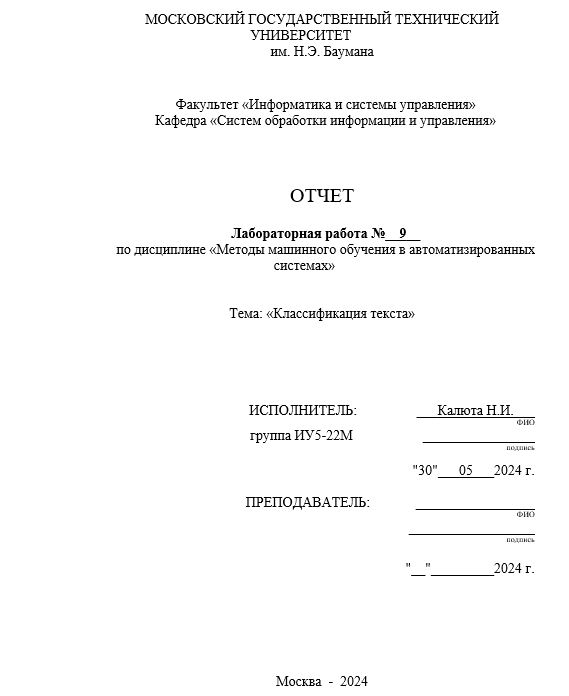

###**Цель лабораторной работы:**
Изучение методов классификации текстов.

###**Задание:**

Для произвольного набора данных, предназначенного для классификации текстов, решите задачу классификации текста двумя способами:

* Способ 1. На основе CountVectorizer или TfidfVectorizer.
* Способ 2. На основе моделей word2vec или Glove или fastText.
Сравните качество полученных моделей.

Импортирование необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time
import gensim.downloader as api
from tqdm import tqdm
import sys

Подключение гугл диска

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Загрузка данных
train_data = pd.read_csv('/content/drive/MyDrive/RK/Electric_train.csv', encoding='latin1')
test_data = pd.read_csv('/content/drive/MyDrive/RK/Electric_test.csv', encoding='latin1')

In [4]:
train_data.shape

(149503, 17)

In [5]:
train_data.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,WBY8P6C58K,King,Seattle,WA,98115.0,2019.0,BMW,I3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,153.0,0.0,43.0,259254397.0,POINT (-122.3008235 47.6862671),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303300e+10
1,5YJSA1DN4D,Kitsap,Bremerton,WA,98312.0,2013.0,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208.0,69900.0,35.0,127420940.0,POINT (-122.6961203 47.5759584),PUGET SOUND ENERGY INC,5.303508e+10
2,5YJSA1E26J,King,Kent,WA,98042.0,2018.0,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,249.0,0.0,47.0,170287183.0,POINT (-122.1145138 47.3581107),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10
3,WBY2Z2C54E,King,Bellevue,WA,98004.0,2014.0,BMW,I8,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,14.0,0.0,41.0,205545868.0,POINT (-122.202397 47.619252),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303302e+10
4,5YJXCDE23J,King,Bellevue,WA,98004.0,2018.0,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,238.0,0.0,41.0,237977386.0,POINT (-122.202397 47.619252),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303302e+10


In [6]:
test_data.shape

(37376, 17)

In [7]:
test_data.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,1GYKPSRL2R,Spokane,Newman Lake,WA,99025.0,2024.0,CADILLAC,LYRIQ,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,4.0,261204632.0,POINT (-117.075672 47.736783),BONNEVILLE POWER ADMINISTRATION||AVISTA CORP||...,5.306301e+10
1,KM8KRDAF1P,Snohomish,Mountlake Terrace,WA,98043.0,2023.0,HYUNDAI,IONIQ 5,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,1.0,260855038.0,POINT (-122.306706 47.792043),PUGET SOUND ENERGY INC,5.306105e+10
2,7SAYGDEF3P,King,Seattle,WA,98101.0,2023.0,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,43.0,236290512.0,POINT (-122.3340795 47.6099315),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
3,7SAYGDEE6P,King,Newcastle,WA,98056.0,2023.0,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,41.0,241560420.0,POINT (-122.1819876 47.5098889),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303302e+10
4,JTMEB3FV3M,San Juan,Friday Harbor,WA,98250.0,2021.0,TOYOTA,RAV4 PRIME,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,42.0,0.0,40.0,142824888.0,POINT (-123.0679454 48.5327669),BONNEVILLE POWER ADMINISTRATION||ORCAS POWER &...,5.305596e+10


In [8]:
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [9]:
X_train = train_data['City']
y_train = train_data['Electric Vehicle Type']

X_test = test_data['City']
y_test = test_data['Electric Vehicle Type']

In [10]:
def check_missing(data, name):
    missing = data.isnull().sum()
    print(f'У {name} {missing} пропущенных строк')

In [11]:
check_missing(train_data, 'train_data')
check_missing(test_data, 'test_data')
check_missing(X_train, 'X_train')
check_missing(X_test, 'X_test')
check_missing(y_train, 'y_train')
check_missing(y_test, 'y_test')

У train_data VIN (1-10)                                           0
County                                               0
City                                                 0
State                                                0
Postal Code                                          0
Model Year                                           0
Make                                                 0
Model                                                0
Electric Vehicle Type                                0
Clean Alternative Fuel Vehicle (CAFV) Eligibility    0
Electric Range                                       0
Base MSRP                                            0
Legislative District                                 0
DOL Vehicle ID                                       0
Vehicle Location                                     0
Electric Utility                                     0
2020 Census Tract                                    0
dtype: int64 пропущенных строк
У test_data VIN (1-10

In [12]:
# Векторизация с помощью CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)

# Векторизация с помощью TfidfVectorizer
tfidf_vect = TfidfVectorizer()
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

In [13]:
# Загрузка предобученных моделей
word2vec_model = api.load('word2vec-google-news-300')
glove_model = api.load('glove-twitter-200')
fasttext_model = api.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded
[==================================================] 100.0% 758.5/758.5MB downloaded
[==================================================] 100.0% 958.5/958.4MB downloaded


In [14]:
# Функция для усреднения векторов слов в тексте
def vectorize_text(text, model):
    words = text.split()
    vectors = [model[word] for word in words if word in model]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

# Векторизация данных
def vectorize_dataset(dataset, model, desc="Vectorizing"):
    return np.array([vectorize_text(text, model) for text in tqdm(dataset, desc=desc)])

In [15]:
X_train_w2v = vectorize_dataset(X_train, word2vec_model, desc="Vectorizing word2vec")
X_test_w2v = vectorize_dataset(X_test, word2vec_model, desc="Vectorizing word2vec")

X_train_glove = vectorize_dataset(X_train, glove_model, desc="Vectorizing Glove")
X_test_glove = vectorize_dataset(X_test, glove_model, desc="Vectorizing Glove")

X_train_fasttext = vectorize_dataset(X_train, fasttext_model, desc="Vectorizing fastText")
X_test_fasttext = vectorize_dataset(X_test, fasttext_model, desc="Vectorizing fastText")

Vectorizing fastText: 100%|██████████| 36992/36992 [00:00<00:00, 45884.06it/s]


In [16]:
# Функции для оценки точности для каждой метки
def accuracy_score_for_classes(y_true, y_pred):
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    classes = np.unique(y_true)
    res = dict()
    for c in classes:
        temp_data_flt = df[df['t'] == c]
        temp_acc = accuracy_score(temp_data_flt['t'].values, temp_data_flt['p'].values)
        res[c] = temp_acc
    return res

In [17]:
def print_accuracy_score_for_classes(y_true, y_pred):
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs) > 0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [18]:
# Оценка моделей
def evaluate_model(vectorizer_name, vectorizer_train, vectorizer_test, model, model_name):
    start_time = time.time()
    obj_model = model
    obj_model.fit(vectorizer_train, y_train)
    predictions = obj_model.predict(vectorizer_test)

    accuracy = accuracy_score(y_test, predictions)
    duration = (time.time() - start_time) / 60

    print(f'Точность: {accuracy:.4f}, время обучения классификатора: {duration:.2f} мин. ({vectorizer_name} + {model_name})')
    print_accuracy_score_for_classes(y_test, predictions)

In [19]:
classifiers = {
    "RandomForestClassifier": RandomForestClassifier(),
    "LinearSVC": LinearSVC(max_iter=10000),
    "LogisticRegression": LogisticRegression(max_iter=10000)
}

vectorizers = {
    "CountVectorizer": (X_train_counts, X_test_counts),
    "TfidfVectorizer": (X_train_tfidf, X_test_tfidf),
    "word2vec": (X_train_w2v, X_test_w2v),
    "glove": (X_train_glove, X_test_glove),
    "fastText": (X_train_fasttext, X_test_fasttext)
}

In [20]:
for vec_name, (train_vec, test_vec) in vectorizers.items():
    for clf_name, clf in classifiers.items():
        evaluate_model(vec_name, train_vec, test_vec, clf, clf_name)

Точность: 0.7792, время обучения классификатора: 0.24 мин. (CountVectorizer + RandomForestClassifier)
Метка 	 Accuracy
Battery Electric Vehicle (BEV) 	 0.9950500190383883
Plug-in Hybrid Electric Vehicle (PHEV) 	 0.009749475502900161
Точность: 0.7793, время обучения классификатора: 0.03 мин. (CountVectorizer + LinearSVC)
Метка 	 Accuracy
Battery Electric Vehicle (BEV) 	 0.9955346325591056
Plug-in Hybrid Electric Vehicle (PHEV) 	 0.008515364679748241
Точность: 0.7794, время обучения классификатора: 0.03 мин. (CountVectorizer + LogisticRegression)
Метка 	 Accuracy
Battery Electric Vehicle (BEV) 	 0.9961923223372218
Plug-in Hybrid Electric Vehicle (PHEV) 	 0.006417376280389979
Точность: 0.7790, время обучения классификатора: 0.26 мин. (TfidfVectorizer + RandomForestClassifier)
Метка 	 Accuracy
Battery Electric Vehicle (BEV) 	 0.9946692512721105
Plug-in Hybrid Electric Vehicle (PHEV) 	 0.009996297667530544
Точность: 0.7793, время обучения классификатора: 0.02 мин. (TfidfVectorizer + LinearS

### Итог
Наилучший результат получен с использованием CountVectorizer и LogisticRegression.